In [292]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split,Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [293]:
# train = pd.read_csv('C:/Users/MJ/Desktop/FunctionApproximation/train.csv')
# test =pd.read_csv('C:/Users/MJ/Desktop/FunctionApproximation/test.csv')
# val_size = int(0.2 * len(train))
# train_size=len(train)-val_size
# train, valid = random_split(train,[train_size, val_size])

In [294]:
cuda = True if torch.cuda.is_available() else False

In [295]:
train=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/train.csv")
test=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/test.csv")

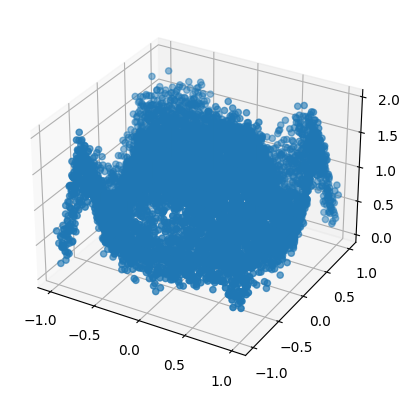

In [426]:
ax=plt.axes(projection='3d')
ax.scatter(train['x1'],train['x2'],train['y'])

In [296]:
class FADataset(Dataset):
    def __init__(self, data,train=True):
        super().__init__()
        if(train):
            self.x=data.drop(['id','y'],axis=1).values
            self.x=torch.tensor(self.x,dtype=torch.float32)
            self.y=torch.tensor(data['y'].values,dtype=torch.float32)
        else:
            self.x=data.drop(['id'],axis=1).values
            self.x=torch.tensor(self.x,dtype=torch.float32)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        data=self.x[idx]
        target=self.y[idx]
        return data,target,idx

    # def update_loss_value(self, idx):
    #     self.flag[idx] = True
        

In [297]:
batch_size=80
dataset=FADataset(train,train=True)
trainset, validset = random_split(dataset, [0.9, 0.1])
train_dl= DataLoader(trainset, shuffle=True, batch_size=batch_size)
valid_dl= DataLoader(validset, shuffle=True, batch_size=batch_size)
testset=FADataset(test,train=False)
test_dl=DataLoader(testset,shuffle=False, batch_size=batch_size)

In [427]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_hidden1, num_hidden2,num_hidden3,num_hidden4,num_hidden5,num_hidden6, output_dim):
        super().__init__()
        self.model=nn.Sequential(nn.Linear(input_dim,num_hidden1),
                                nn.ReLU(True),
                                nn.Linear(num_hidden1,num_hidden2),
                                nn.ReLU(True),
                                nn.Linear(num_hidden2,num_hidden3),
                                nn.ReLU(True),
                                nn.Linear(num_hidden3,num_hidden4),
                                nn.ReLU(True),  
                                nn.Linear(num_hidden4,num_hidden5),
                                nn.ReLU(True),  
                                nn.Linear(num_hidden5,num_hidden6),
                                nn.Linear(num_hidden6,output_dim)
                                )
    def forward(self, x):
        return self.model(x)


In [299]:
model= MLP(input_dim=2, num_hidden1=80,num_hidden2=128,num_hidden3=256,num_hidden4=512,num_hidden5=256,num_hidden6=128, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [428]:
num_epochs = 50
losses=[]
size = len(train_dl)
model.train()
for epoch in range(num_epochs):
    losses=[]
    for batch,(data, target,idx) in enumerate(train_dl):
        outputs = model(data)
        loss = criterion(outputs.reshape(-1), target.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 80 == 0: #每通過batch個數量的資料就輸出一次損失的值
            # print(f"loss: {loss.item():>7f} ")
            losses.append(loss.item())
        
    print("lossmean=:",sum(losses)/len(losses))

lossmean=: 0.026325314305722713
lossmean=: 0.024865154176950455
lossmean=: 0.02410639263689518
lossmean=: 0.029260803945362568
lossmean=: 0.02846354804933071
lossmean=: 0.031089067459106445
lossmean=: 0.026819048449397087
lossmean=: 0.02737455628812313
lossmean=: 0.024287955835461617
lossmean=: 0.03114601131528616
lossmean=: 0.029533361084759235
lossmean=: 0.026981189846992493
lossmean=: 0.03288240544497967
lossmean=: 0.027536943554878235
lossmean=: 0.0297669880092144
lossmean=: 0.025715431198477745
lossmean=: 0.03056461736559868
lossmean=: 0.025489539839327335
lossmean=: 0.03777620755136013
lossmean=: 0.02851735334843397
lossmean=: 0.03012300468981266
lossmean=: 0.02705708798021078
lossmean=: 0.024097496643662453
lossmean=: 0.026316587813198566
lossmean=: 0.027226866222918034
lossmean=: 0.030560314655303955
lossmean=: 0.024640641175210476
lossmean=: 0.024157226085662842
lossmean=: 0.027701585553586483
lossmean=: 0.029885413125157356
lossmean=: 0.022491625510156155
lossmean=: 0.0238726

In [430]:
min(losses)

0.024738609790802002

In [431]:
model.eval()
losses=[]
for batch,(data, target,idx) in enumerate(valid_dl):
    outputs = model(data)
    loss = criterion(outputs.reshape(-1), target.reshape(-1))
    losses.append(loss.item())
print(f"loss: {sum(losses)/len(losses):>7f} ")

loss: 0.024005 


In [432]:
model.eval()
output=[]
for i in range(len(testset)):
    output.append((model(testset.x[i])).item())

In [433]:
min(output)

0.45771411061286926

In [434]:
sample_submission=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/sample_submission.csv")
sample_submission['y']=output
sample_submission.to_csv("C:/Users/MJ/Desktop/sample_submission.csv",index=False)

In [306]:
import optuna

In [419]:
def build_model(params):
    
    input_dim = 2
    output_dim=1
    return nn.Sequential(
                            nn.Linear(input_dim,params['num_hidden1']),
                            nn.ReLU(True),
                            nn.Linear(params['num_hidden1'],params['num_hidden2']),
                            nn.ReLU(True),
                            nn.Linear(params['num_hidden2'],params['num_hidden3']),
                            nn.ReLU(True),
                            nn.Linear(params['num_hidden3'],params['num_hidden4']),
                            nn.ReLU(True),  
                            nn.Dropout(0.5),
                            nn.Linear(params['num_hidden4'],params['num_hidden5']),
                            nn.ReLU(True),  
                            nn.Linear(params['num_hidden5'],params['num_hidden6']),
                            nn.ReLU(True),  
                            nn.Linear(params['num_hidden6'],params['num_hidden7']),
                            nn.ReLU(True),  
                            nn.Linear(params['num_hidden7'],params['num_hidden8']),
                            nn.ReLU(True),  
                            nn.Linear(params['num_hidden8'],params['num_hidden9']),
                            nn.ReLU(True),  
                            nn.Linear(params['num_hidden9'],params['num_hidden10']),
                            nn.Linear(params['num_hidden10'],output_dim)
                        )

In [420]:
def train_and_evaluate(params,model):

    optimizer = getattr(torch.optim, params['optimizer'])(model.parameters(), lr= params['learning_rate'])
    

    dataset=FADataset(train,train=True)
    trainset, validset = random_split(dataset, [0.9, 0.1])
    train_dl= DataLoader(trainset, shuffle=True, batch_size=params['batch_size'])
    valid_dl= DataLoader(validset, shuffle=True, batch_size=params['batch_size'])
    
    criterion = nn.MSELoss()

    losses=[]
    num_epochs=50
    model.train()
    for epoch in range(num_epochs):
        for batch,(data, target,idx) in enumerate(train_dl):
            outputs = model(data)
            loss = criterion(outputs.reshape(-1), target.reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    model.eval()
    losses=[]
    for batch,(data, target,idx) in enumerate(valid_dl):
        outputs = model(data)
        loss = criterion(outputs.reshape(-1), target.reshape(-1))
        losses.append(loss.item())
    print(f"loss: {sum(losses)/len(losses):>7f} ")
    loss=sum(losses)/len(losses)
    
    return model,loss


In [421]:

def objective(trial):
        
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1),
            'optimizer': trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
            'num_hidden1': trial.suggest_int("num_hidden1", 50, 500),
            'num_hidden2': trial.suggest_int("num_hidden2", 50, 600),
            'num_hidden3': trial.suggest_int("num_hidden3", 50, 600),
            'num_hidden4': trial.suggest_int("num_hidden4", 50, 600),
            'num_hidden5': trial.suggest_int("num_hidden5", 50, 600),
            'num_hidden6': trial.suggest_int("num_hidden6", 50, 600),
            'num_hidden7': trial.suggest_int("num_hidden7", 50, 600),
            'num_hidden8': trial.suggest_int("num_hidden8", 50, 600),
            'num_hidden9': trial.suggest_int("num_hidden9", 50, 600),
            'num_hidden10': trial.suggest_int("num_hidden10", 50, 600),
            'batch_size': trial.suggest_int("batch_size", 64, 320,step=16)
            }
    

        model= build_model(params)
        best_model,loss=train_and_evaluate(params,model)
      
        torch.save(best_model.state_dict(), f"model_trial_{trial.number}.pth")
    
        return loss

In [422]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2023-04-30 15:37:17,106] A new study created in memory with name: no-name-1455650c-fb8c-4262-99e3-9dfb91c4e135
[I 2023-04-30 15:37:41,845] Trial 0 finished with value: 47442.9375 and parameters: {'learning_rate': 0.08195376795556801, 'optimizer': 'Adam', 'num_hidden1': 115, 'num_hidden2': 566, 'num_hidden3': 210, 'num_hidden4': 218, 'num_hidden5': 559, 'num_hidden6': 293, 'num_hidden7': 117, 'num_hidden8': 405, 'num_hidden9': 354, 'num_hidden10': 335, 'batch_size': 224}. Best is trial 0 with value: 47442.9375.


loss: 47442.937500 


[I 2023-04-30 15:38:10,203] Trial 1 finished with value: 0.14472025334835054 and parameters: {'learning_rate': 0.09039861481448115, 'optimizer': 'Adam', 'num_hidden1': 459, 'num_hidden2': 403, 'num_hidden3': 69, 'num_hidden4': 364, 'num_hidden5': 515, 'num_hidden6': 432, 'num_hidden7': 151, 'num_hidden8': 298, 'num_hidden9': 218, 'num_hidden10': 174, 'batch_size': 192}. Best is trial 1 with value: 0.14472025334835054.


loss: 0.144720 


[I 2023-04-30 15:38:28,411] Trial 2 finished with value: 0.14722107723355293 and parameters: {'learning_rate': 0.08012120108345216, 'optimizer': 'SGD', 'num_hidden1': 125, 'num_hidden2': 515, 'num_hidden3': 252, 'num_hidden4': 499, 'num_hidden5': 519, 'num_hidden6': 449, 'num_hidden7': 269, 'num_hidden8': 206, 'num_hidden9': 281, 'num_hidden10': 441, 'batch_size': 240}. Best is trial 1 with value: 0.14472025334835054.


loss: 0.147221 


[I 2023-04-30 15:39:02,751] Trial 3 finished with value: 0.027020244300365447 and parameters: {'learning_rate': 0.008695247714248878, 'optimizer': 'Adam', 'num_hidden1': 312, 'num_hidden2': 572, 'num_hidden3': 313, 'num_hidden4': 538, 'num_hidden5': 155, 'num_hidden6': 461, 'num_hidden7': 243, 'num_hidden8': 324, 'num_hidden9': 410, 'num_hidden10': 295, 'batch_size': 176}. Best is trial 3 with value: 0.027020244300365447.


loss: 0.027020 


[I 2023-04-30 15:39:41,246] Trial 4 finished with value: 871335.4821428572 and parameters: {'learning_rate': 0.06648004803990497, 'optimizer': 'Adam', 'num_hidden1': 273, 'num_hidden2': 140, 'num_hidden3': 352, 'num_hidden4': 510, 'num_hidden5': 81, 'num_hidden6': 561, 'num_hidden7': 216, 'num_hidden8': 488, 'num_hidden9': 226, 'num_hidden10': 316, 'batch_size': 128}. Best is trial 3 with value: 0.027020244300365447.


loss: 871335.482143 


[I 2023-04-30 15:40:00,552] Trial 5 finished with value: 0.09342879988253117 and parameters: {'learning_rate': 0.09517162533035468, 'optimizer': 'SGD', 'num_hidden1': 457, 'num_hidden2': 377, 'num_hidden3': 124, 'num_hidden4': 417, 'num_hidden5': 587, 'num_hidden6': 89, 'num_hidden7': 561, 'num_hidden8': 237, 'num_hidden9': 190, 'num_hidden10': 382, 'batch_size': 112}. Best is trial 3 with value: 0.027020244300365447.


loss: 0.093429 


[I 2023-04-30 15:40:12,522] Trial 6 finished with value: 0.14543878436088561 and parameters: {'learning_rate': 0.060304269311681785, 'optimizer': 'SGD', 'num_hidden1': 209, 'num_hidden2': 152, 'num_hidden3': 357, 'num_hidden4': 164, 'num_hidden5': 571, 'num_hidden6': 73, 'num_hidden7': 421, 'num_hidden8': 247, 'num_hidden9': 263, 'num_hidden10': 177, 'batch_size': 192}. Best is trial 3 with value: 0.027020244300365447.


loss: 0.145439 


[I 2023-04-30 15:40:29,912] Trial 7 finished with value: 0.1451923151810964 and parameters: {'learning_rate': 0.036134135726188385, 'optimizer': 'Adam', 'num_hidden1': 314, 'num_hidden2': 103, 'num_hidden3': 121, 'num_hidden4': 516, 'num_hidden5': 256, 'num_hidden6': 277, 'num_hidden7': 290, 'num_hidden8': 436, 'num_hidden9': 270, 'num_hidden10': 516, 'batch_size': 320}. Best is trial 3 with value: 0.027020244300365447.


loss: 0.145192 


[I 2023-04-30 15:40:44,759] Trial 8 finished with value: 0.15578573942184448 and parameters: {'learning_rate': 0.07082601707010859, 'optimizer': 'SGD', 'num_hidden1': 360, 'num_hidden2': 155, 'num_hidden3': 331, 'num_hidden4': 349, 'num_hidden5': 406, 'num_hidden6': 156, 'num_hidden7': 298, 'num_hidden8': 592, 'num_hidden9': 93, 'num_hidden10': 573, 'batch_size': 160}. Best is trial 3 with value: 0.027020244300365447.


loss: 0.155786 


[I 2023-04-30 15:41:04,537] Trial 9 finished with value: 0.18001708388328552 and parameters: {'learning_rate': 0.07893936139794439, 'optimizer': 'SGD', 'num_hidden1': 356, 'num_hidden2': 197, 'num_hidden3': 594, 'num_hidden4': 234, 'num_hidden5': 339, 'num_hidden6': 54, 'num_hidden7': 299, 'num_hidden8': 463, 'num_hidden9': 537, 'num_hidden10': 279, 'batch_size': 128}. Best is trial 3 with value: 0.027020244300365447.


loss: 0.180017 


[I 2023-04-30 15:42:14,587] Trial 10 finished with value: 0.022533117979764938 and parameters: {'learning_rate': 0.002577532936883683, 'optimizer': 'Adam', 'num_hidden1': 203, 'num_hidden2': 473, 'num_hidden3': 476, 'num_hidden4': 586, 'num_hidden5': 90, 'num_hidden6': 583, 'num_hidden7': 421, 'num_hidden8': 62, 'num_hidden9': 451, 'num_hidden10': 139, 'batch_size': 80}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.022533 


[I 2023-04-30 15:43:40,188] Trial 11 finished with value: 0.09913117094681813 and parameters: {'learning_rate': 0.005919485959585127, 'optimizer': 'Adam', 'num_hidden1': 215, 'num_hidden2': 467, 'num_hidden3': 524, 'num_hidden4': 594, 'num_hidden5': 51, 'num_hidden6': 591, 'num_hidden7': 413, 'num_hidden8': 51, 'num_hidden9': 446, 'num_hidden10': 60, 'batch_size': 64}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.099131 


[I 2023-04-30 15:45:17,057] Trial 12 finished with value: 0.025514404790905807 and parameters: {'learning_rate': 0.0029924678841168314, 'optimizer': 'Adam', 'num_hidden1': 210, 'num_hidden2': 587, 'num_hidden3': 454, 'num_hidden4': 594, 'num_hidden5': 149, 'num_hidden6': 482, 'num_hidden7': 429, 'num_hidden8': 105, 'num_hidden9': 424, 'num_hidden10': 187, 'batch_size': 64}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.025514 


[I 2023-04-30 15:46:19,240] Trial 13 finished with value: 0.08228810045581597 and parameters: {'learning_rate': 0.0010910106078272455, 'optimizer': 'Adam', 'num_hidden1': 187, 'num_hidden2': 273, 'num_hidden3': 462, 'num_hidden4': 61, 'num_hidden5': 173, 'num_hidden6': 518, 'num_hidden7': 434, 'num_hidden8': 51, 'num_hidden9': 573, 'num_hidden10': 64, 'batch_size': 64}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.082288 


[I 2023-04-30 15:47:35,547] Trial 14 finished with value: 0.14448724389076234 and parameters: {'learning_rate': 0.02154271027948711, 'optimizer': 'Adam', 'num_hidden1': 75, 'num_hidden2': 473, 'num_hidden3': 445, 'num_hidden4': 593, 'num_hidden5': 197, 'num_hidden6': 382, 'num_hidden7': 532, 'num_hidden8': 153, 'num_hidden9': 451, 'num_hidden10': 192, 'batch_size': 80}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.144487 


[I 2023-04-30 15:48:36,090] Trial 15 finished with value: 0.1425615499416987 and parameters: {'learning_rate': 0.022539091474781222, 'optimizer': 'Adam', 'num_hidden1': 166, 'num_hidden2': 291, 'num_hidden3': 452, 'num_hidden4': 440, 'num_hidden5': 130, 'num_hidden6': 521, 'num_hidden7': 487, 'num_hidden8': 130, 'num_hidden9': 494, 'num_hidden10': 133, 'batch_size': 96}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.142562 


[I 2023-04-30 15:49:23,783] Trial 16 finished with value: 0.14668932060400644 and parameters: {'learning_rate': 0.041093981799603725, 'optimizer': 'Adam', 'num_hidden1': 247, 'num_hidden2': 587, 'num_hidden3': 552, 'num_hidden4': 419, 'num_hidden5': 269, 'num_hidden6': 352, 'num_hidden7': 380, 'num_hidden8': 122, 'num_hidden9': 364, 'num_hidden10': 222, 'batch_size': 144}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.146689 


[I 2023-04-30 15:50:28,491] Trial 17 finished with value: 0.06227787584066391 and parameters: {'learning_rate': 0.016377750437179026, 'optimizer': 'Adam', 'num_hidden1': 152, 'num_hidden2': 410, 'num_hidden3': 425, 'num_hidden4': 599, 'num_hidden5': 235, 'num_hidden6': 532, 'num_hidden7': 489, 'num_hidden8': 100, 'num_hidden9': 508, 'num_hidden10': 109, 'batch_size': 96}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.062278 


[I 2023-04-30 15:50:50,916] Trial 18 finished with value: 31387.470052083332 and parameters: {'learning_rate': 0.029639116579972046, 'optimizer': 'Adam', 'num_hidden1': 51, 'num_hidden2': 516, 'num_hidden3': 513, 'num_hidden4': 279, 'num_hidden5': 115, 'num_hidden6': 598, 'num_hidden7': 359, 'num_hidden8': 186, 'num_hidden9': 597, 'num_hidden10': 243, 'batch_size': 288}. Best is trial 10 with value: 0.022533117979764938.


loss: 31387.470052 


[I 2023-04-30 15:51:45,736] Trial 19 finished with value: 0.09675829733411472 and parameters: {'learning_rate': 0.012950077986885859, 'optimizer': 'Adam', 'num_hidden1': 242, 'num_hidden2': 353, 'num_hidden3': 403, 'num_hidden4': 482, 'num_hidden5': 346, 'num_hidden6': 241, 'num_hidden7': 473, 'num_hidden8': 83, 'num_hidden9': 386, 'num_hidden10': 132, 'batch_size': 96}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.096758 


[I 2023-04-30 15:53:35,819] Trial 20 finished with value: 0.030203712387726858 and parameters: {'learning_rate': 0.002390219261032181, 'optimizer': 'Adam', 'num_hidden1': 392, 'num_hidden2': 460, 'num_hidden3': 490, 'num_hidden4': 557, 'num_hidden5': 432, 'num_hidden6': 483, 'num_hidden7': 54, 'num_hidden8': 365, 'num_hidden9': 451, 'num_hidden10': 386, 'batch_size': 64}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.030204 


[I 2023-04-30 15:54:13,739] Trial 21 finished with value: 0.03948938474059105 and parameters: {'learning_rate': 0.009426091184680976, 'optimizer': 'Adam', 'num_hidden1': 309, 'num_hidden2': 598, 'num_hidden3': 260, 'num_hidden4': 544, 'num_hidden5': 155, 'num_hidden6': 411, 'num_hidden7': 208, 'num_hidden8': 313, 'num_hidden9': 408, 'num_hidden10': 253, 'batch_size': 160}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.039489 


[I 2023-04-30 15:54:40,709] Trial 22 finished with value: 0.029537657275795937 and parameters: {'learning_rate': 0.0006401777967667999, 'optimizer': 'Adam', 'num_hidden1': 305, 'num_hidden2': 537, 'num_hidden3': 391, 'num_hidden4': 463, 'num_hidden5': 97, 'num_hidden6': 465, 'num_hidden7': 357, 'num_hidden8': 168, 'num_hidden9': 323, 'num_hidden10': 295, 'batch_size': 224}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.029538 


[I 2023-04-30 15:55:09,224] Trial 23 finished with value: 0.056044469277064 and parameters: {'learning_rate': 0.012896334609810888, 'optimizer': 'Adam', 'num_hidden1': 266, 'num_hidden2': 546, 'num_hidden3': 290, 'num_hidden4': 546, 'num_hidden5': 204, 'num_hidden6': 498, 'num_hidden7': 237, 'num_hidden8': 569, 'num_hidden9': 420, 'num_hidden10': 201, 'batch_size': 272}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.056044 


[I 2023-04-30 15:56:05,872] Trial 24 finished with value: 0.870899498462677 and parameters: {'learning_rate': 0.022218060546871265, 'optimizer': 'Adam', 'num_hidden1': 229, 'num_hidden2': 488, 'num_hidden3': 595, 'num_hidden4': 549, 'num_hidden5': 54, 'num_hidden6': 554, 'num_hidden7': 593, 'num_hidden8': 538, 'num_hidden9': 482, 'num_hidden10': 117, 'batch_size': 160}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.870899 


[I 2023-04-30 15:56:55,346] Trial 25 finished with value: 0.0880842125043273 and parameters: {'learning_rate': 0.007606037765390377, 'optimizer': 'Adam', 'num_hidden1': 411, 'num_hidden2': 431, 'num_hidden3': 380, 'num_hidden4': 378, 'num_hidden5': 137, 'num_hidden6': 406, 'num_hidden7': 168, 'num_hidden8': 268, 'num_hidden9': 328, 'num_hidden10': 368, 'batch_size': 112}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.088084 


[I 2023-04-30 15:57:24,398] Trial 26 finished with value: 0.256068754196167 and parameters: {'learning_rate': 6.462404772696528e-05, 'optimizer': 'SGD', 'num_hidden1': 186, 'num_hidden2': 580, 'num_hidden3': 215, 'num_hidden4': 562, 'num_hidden5': 288, 'num_hidden6': 355, 'num_hidden7': 324, 'num_hidden8': 371, 'num_hidden9': 557, 'num_hidden10': 433, 'batch_size': 80}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.256069 


[I 2023-04-30 15:57:56,301] Trial 27 finished with value: 0.14433883130550385 and parameters: {'learning_rate': 0.015260218225814182, 'optimizer': 'Adam', 'num_hidden1': 330, 'num_hidden2': 512, 'num_hidden3': 291, 'num_hidden4': 462, 'num_hidden5': 176, 'num_hidden6': 461, 'num_hidden7': 399, 'num_hidden8': 206, 'num_hidden9': 525, 'num_hidden10': 270, 'batch_size': 208}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.144339 


[I 2023-04-30 15:58:35,443] Trial 28 finished with value: 0.1419489562511444 and parameters: {'learning_rate': 0.048117570356148075, 'optimizer': 'Adam', 'num_hidden1': 285, 'num_hidden2': 546, 'num_hidden3': 481, 'num_hidden4': 300, 'num_hidden5': 232, 'num_hidden6': 571, 'num_hidden7': 440, 'num_hidden8': 109, 'num_hidden9': 397, 'num_hidden10': 154, 'batch_size': 176}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.141949 


[I 2023-04-30 15:58:59,697] Trial 29 finished with value: 0.034060790669173 and parameters: {'learning_rate': 0.008339084301822028, 'optimizer': 'Adam', 'num_hidden1': 126, 'num_hidden2': 565, 'num_hidden3': 179, 'num_hidden4': 515, 'num_hidden5': 88, 'num_hidden6': 292, 'num_hidden7': 346, 'num_hidden8': 369, 'num_hidden9': 334, 'num_hidden10': 344, 'batch_size': 256}. Best is trial 10 with value: 0.022533117979764938.


loss: 0.034061 


In [423]:
study.best_params

{'learning_rate': 0.002577532936883683,
 'optimizer': 'Adam',
 'num_hidden1': 203,
 'num_hidden2': 473,
 'num_hidden3': 476,
 'num_hidden4': 586,
 'num_hidden5': 90,
 'num_hidden6': 583,
 'num_hidden7': 421,
 'num_hidden8': 62,
 'num_hidden9': 451,
 'num_hidden10': 139,
 'batch_size': 80}

In [399]:
study.best_value

0.023161600447363324

In [400]:
display(optuna.visualization.plot_param_importances(study))
display(optuna.visualization.plot_parallel_coordinate(study))
display(optuna.visualization.plot_optimization_history(study))

In [371]:
def best(params):
 
    model= build_model(params)
    optimizer = getattr(torch.optim, params['optimizer'])(model.parameters(), lr= params['learning_rate'])
    

    dataset=FADataset(train,train=True)
    trainset, validset = random_split(dataset, [0.9, 0.1])
    train_dl= DataLoader(trainset, shuffle=True, batch_size=params['batch_size'])
    valid_dl= DataLoader(validset, shuffle=True, batch_size=params['batch_size'])

   
    criterion = nn.MSELoss()

    losses=[]
    size = len(train_dl)
    model.train()
    for epoch in range(num_epochs):
        for batch,(data, target,idx) in enumerate(train_dl):
            outputs = model(data)
            loss = criterion(outputs.reshape(-1), target.reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    model.eval()
    losses=[]
    for batch,(data, target,idx) in enumerate(valid_dl):
        outputs = model(data)
        loss = criterion(outputs.reshape(-1), target.reshape(-1))
        losses.append(loss.item())
    print(f"loss: {sum(losses)/len(losses):>7f} ")
    loss=sum(losses)/len(losses)
    return model,loss

In [401]:
study.best_params['optimizer']

'SGD'

In [364]:
study.best_trial

FrozenTrial(number=20, state=TrialState.COMPLETE, values=[0.021876248427563243], datetime_start=datetime.datetime(2023, 4, 30, 14, 43, 8, 991486), datetime_complete=datetime.datetime(2023, 4, 30, 14, 43, 25, 899312), params={'learning_rate': 0.08449763931393948, 'optimizer': 'SGD', 'num_hidden1': 250, 'num_hidden2': 170, 'num_hidden3': 119, 'num_hidden4': 371, 'num_hidden5': 596, 'num_hidden6': 493, 'num_hidden7': 285, 'batch_size': 96}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=1e-05, step=None), 'optimizer': CategoricalDistribution(choices=('Adam', 'SGD')), 'num_hidden1': IntDistribution(high=500, log=False, low=4, step=1), 'num_hidden2': IntDistribution(high=600, log=False, low=4, step=1), 'num_hidden3': IntDistribution(high=600, log=False, low=4, step=1), 'num_hidden4': IntDistribution(high=600, log=False, low=4, step=1), 'num_hidden5': IntDistribution(high=600, log=False, low=4, step=1), 'num_

In [413]:
model= build_model(study.best_params)
model.load_state_dict(torch.load("C:/Users/MJ/Desktop/FunctionApproximation/model_trial_21.pth"))
model.eval()
losses=[]
for batch,(data, target,idx) in enumerate(valid_dl):
    outputs = model(data)
    loss = criterion(outputs.reshape(-1), target.reshape(-1))
    losses.append(loss.item())
print(f"loss: {sum(losses)/len(losses):>7f} ")
loss=sum(losses)/len(losses)

loss: 0.024005 


In [414]:
model.eval()
output=[]
for i in range(len(testset)):
    output.append((model(testset.x[i])).item())

將test data預測結果存取成 sample_submission.csv

In [415]:
sample_submission=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/sample_submission.csv")
sample_submission['y']=output
sample_submission.to_csv("C:/Users/MJ/Desktop/sample_submission.csv",index=False)

將loss值較大的當成noise data後去除再訓練模型(但此方法loss值大於使用ensemble learning，因此不採用)

In [ ]:
# model=[]
# optimizer=[]

# for i in range(3):
#     model.append(MLP(input_dim=2, num_hidden1=380,num_hidden2=155,num_hidden3=22,num_hidden4=467,num_hidden5=27,num_hidden6=130, output_dim=1))
#     optimizer.append(torch.optim.SGD(model[i].parameters(), lr=0.08115999290485583))
# criterion = nn.MSELoss()

In [ ]:
# model[0].eval()
# indexF=[]
# indexT=[]
# for i in range(len(trainset)):
#     outputs = model[0](trainset.dataset.x[i])
#     loss = criterion(outputs,trainset.dataset.y[i].reshape(1))
#     if(loss<0.08):           #將loss值大於0.08的去除
#         indexT.append(i)

In [ ]:
# Tdataset=torch.utils.data.Subset(trainset, indexT)
# Tdl=DataLoader(Tdataset, shuffle=True, batch_size=batch_size)


# num_epochs = 80
# size = len(Tdl)
# model[1].train()
# for epoch in range(num_epochs):
#     for batch,(data, target,idx) in enumerate(Tdl):
#         outputs = model[1](data)
#         loss = criterion(outputs.reshape(-1), target.reshape(-1))
#         optimizer[1].zero_grad()
#         loss.backward()
#         optimizer[1].step()
#         if batch % 80 == 0: 
#             print(f"loss: {loss.item():>7f} ")
#             losses.append(loss.item())